In [1]:
# INFO ABOut how much money people spend vs how much they have
# both are coorelated to each other since if spend more would have less in account

In [13]:
# pmdarima does not work here 
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Data/M2SLMoneyStock.csv",index_col = 0 , parse_dates = True)
df.index.freq = 'MS'
sp = pd.read_csv("Data/PCEPersonalSpending.csv",index_col = 0 , parse_dates = True)
sp.index.freq = 'MS'

In [16]:
sp.head(), df.head()

(            Spending
 Date                
 1995-01-01    4851.2
 1995-02-01    4850.8
 1995-03-01    4885.4
 1995-04-01    4890.2
 1995-05-01    4933.1,
              Money
 Date              
 1995-01-01  3492.4
 1995-02-01  3489.9
 1995-03-01  3491.1
 1995-04-01  3499.2
 1995-05-01  3524.2)

In [17]:
# joining both on dates 
df = df.join(sp)

In [18]:
df

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


In [19]:
df.shape

(252, 2)

In [21]:
df.dropna()
df.shape
# no null values

(252, 2)

<Axes: xlabel='Date'>

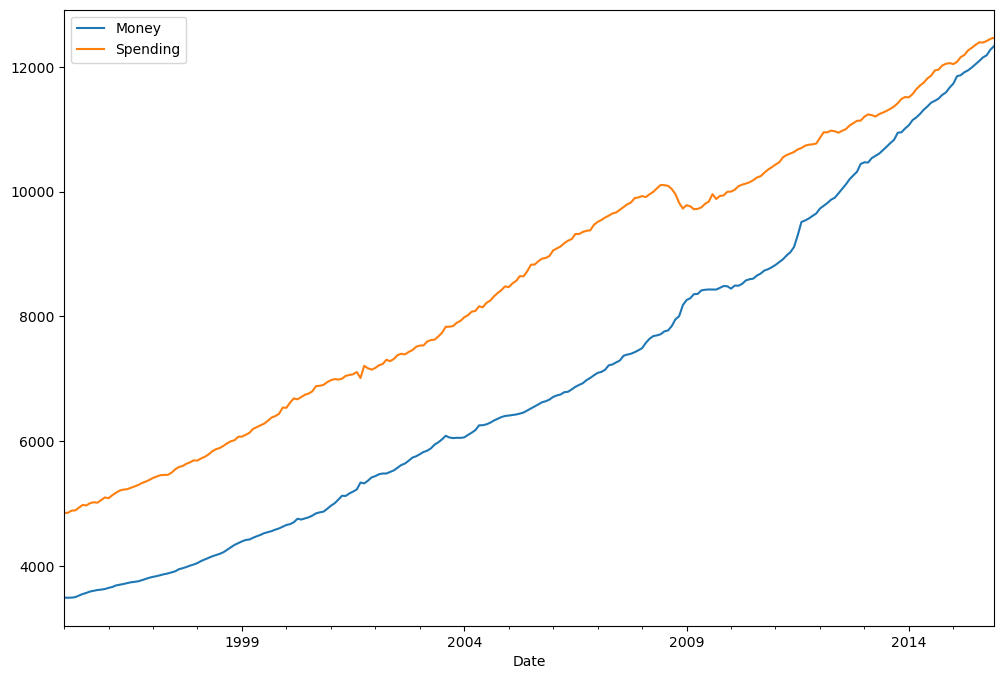

In [23]:
df.plot(figsize = (12,8),legend = True)

In [24]:
## dicky fuller to test the stationarity

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [26]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [27]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [28]:
## we need to differnece both the columns
# whole dataframe can be differenced directly
df_transformed = df.diff()

In [29]:
df_transformed.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


In [30]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [32]:
adf_test(df_transformed['Spending'])
# spedning became stationary 

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [34]:
# wont want to do diff for spending col only so that we have nulls in first 2 rows of spending and 
## one null in money
# also beneficial when we are reverting we can do twice for both columns
df_transformed = df_transformed.diff().dropna()

In [35]:
df_transformed

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7
...,...,...
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5


In [36]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [37]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [38]:
## both are stationary now

In [39]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [40]:
df.shape # lost 2 rows

(252, 2)

In [41]:
nobs = 12

In [42]:
train = df_transformed[:-nobs] # start to end - 12
test = df_transformed[-nobs:] # start-12 to end of df

In [43]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


### GRIDSEARCH
<h4> finding the new orders </h4>
<h5>grid search for order p AR of VAR </h5>

In [49]:
model = VAR(train)

In [50]:
for p in range(8):
    results = model.fit(p)
    print(f'order {p}')
    print(f'AIC: {results.aic}')

order 0
AIC: 14.74710921809045
order 1
AIC: 14.178610495220896
order 2
AIC: 13.955189367163703
order 3
AIC: 13.849518291541038
order 4
AIC: 13.827950574458283
order 5
AIC: 13.78730034460964
order 6
AIC: 13.799076756885809
order 7
AIC: 13.797638727913972


In [52]:
# best order is 5
results = model.fit(5)

In [55]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Sep, 2024
Time:                     15:12:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [57]:
## grab 5 lagged values just before the test df starts  
# get itin numpy array form
train.values[-5:]

array([[-31.9,  40.3],
       [  5.6, -70.7],
       [ 25.5,  52.5],
       [-21.3, -37.2],
       [ 39.5, -17.8]])

In [58]:
lagged_value = train.values[-5:]

In [61]:
z = results.forecast(y = lagged_value, steps = 12)
# one of the arguments is nparray of p*k
# p is the actual logorder (5) , k : speaning and money -> 2
# so in a way we need to pass 

# 12 since 12 steps in future

In [63]:
# these are in differenced form  need to bring these back into original form

In [64]:
#in the original test df we were startinf from : "2015-01-01"
idx = pd.date_range("2015-01-01",periods = 12,freq= 'MS')
## this way we created the index 


DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [65]:
df_forecast = pd.DataFrame(data= z, index = idx,columns = ['money_2d','spending_2d'])

In [66]:
df_forecast

,money_2d,spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [67]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [68]:
## both of these have 2nd diff right now these are also quite close

In [69]:
## reverse diff

In [71]:
# Add the most recent first difference from the training set to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [74]:
# Add the most recent first difference from the training set to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['Spendforecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [75]:
df_forecast

,money_2d,spending_2d,Money1d,MoneyForecast,Spending1d,Spendforecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019


In [76]:
## geting test from original df since the new df has been modified
test_range = df[-nobs:]

In [77]:
test_range

,Money,Spending
Date,,
2015-01-01,11733.2,12046.0
2015-02-01,11852.4,12082.4
2015-03-01,11868.8,12158.3
2015-04-01,11916.1,12193.8
2015-05-01,11947.6,12268.1
2015-06-01,11993.1,12308.3
2015-07-01,12045.3,12355.4
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8


<Axes: xlabel='Date'>

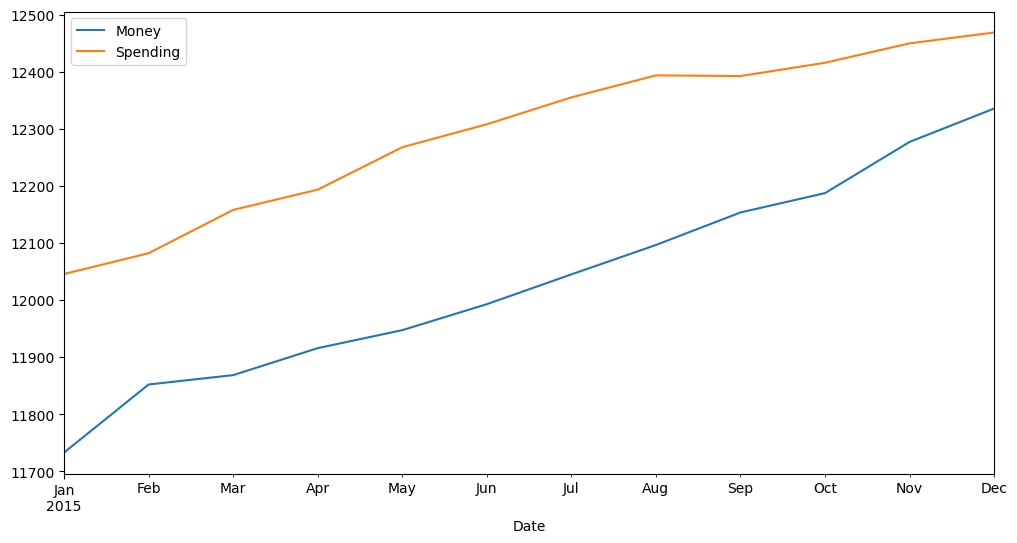

In [78]:
test_range.plot(figsize = (12,6))

<Axes: >

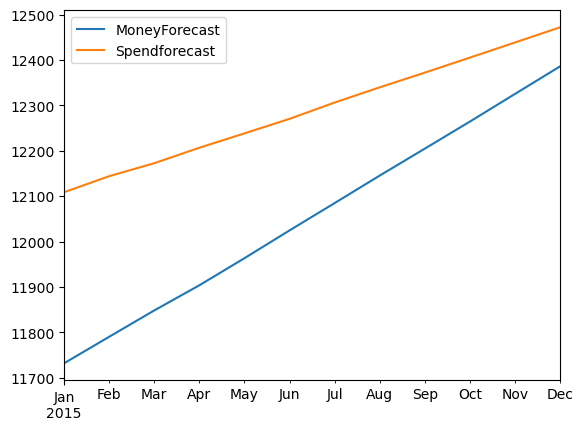

In [80]:
df_forecast[['MoneyForecast','Spendforecast']].plot()

In [81]:
## simpler since much like AR


In [82]:
rmse(test_range['Money'],df_forecast['MoneyForecast'])

43.71049653558893

In [83]:
test_range['Money'].mean()

12034.008333333333

In [84]:
rmse(test_range['Spending'],df_forecast['Spendforecast'])

37.00117516940808

In [85]:
test_range['Spending'].mean()

12294.533333333335